In [9]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings as wr
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from pathlib import Path

wr.filterwarnings('ignore')

work_dir = Path.cwd().parent.parent / 'Work'
df = pd.read_excel(work_dir / "summary_tests.xlsx")

delete_columns = ['id_sample', 'age', 'sex', 'Unnamed: 0']
features = [column for column in df.columns if column not in delete_columns]

#print(df)

In [10]:
X = df.drop(columns=delete_columns)
y = df['age']


def split_data(X_Data, y_Data):
    X_1, X_2, y_1, y_2 = train_test_split(
        X_Data,
        y_Data,
        test_size=0.2,
        random_state=42
    ) 
    return X_1, X_2, y_1, y_2
    

X_train_full, X_test, y_train_full, y_test = split_data(X, y)

X_train, X_val, y_train, y_val = split_data(X_train_full, y_train_full)  #64% - train, 16% - validation, 20% - test

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_val_scaled = scaler.transform(X_val)          
X_test_scaled = scaler.transform(X_test)        

grid_space = {'n_neighbors': [3, 5, 7, 10, 15, 20, 25, 30],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'minkowski', 'cosine', 'chebyshev']
}

grid = GridSearchCV(KNeighborsRegressor(), 
                    grid_space, 
                    cv=5, 
                    scoring='neg_mean_absolute_error'
)

grid.fit(X_train_scaled, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший результат:", grid.best_score_)

knn = KNeighborsRegressor(n_neighbors=15, weights='distance', metric='manhattan') #обучяем модель
knn.fit(X_train_scaled, y_train)

y_train_pred = knn.predict(X_train_scaled)  # используем модель на обучающей выборке
train_mae = mean_absolute_error(y_train, y_train_pred)
print("MAE при обучающей выборке:", train_mae)

y_val_pred = knn.predict(X_val_scaled)  # используем модель на валидационной выборке
val_mae = mean_absolute_error(y_val, y_val_pred)
print("MAE при валидационной выборке:", val_mae)

y_test_pred = knn.predict(X_test_scaled)  #на тестовой
test_mae = mean_absolute_error(y_test, y_test_pred)
print("MAE при тестовой выборке:", test_mae)

Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
Лучший результат: -8.42842428914893
MAE при обучающей выборке: 0.0
MAE при валидационной выборке: 7.831656696448341
MAE при тестовой выборке: 9.0788440837908


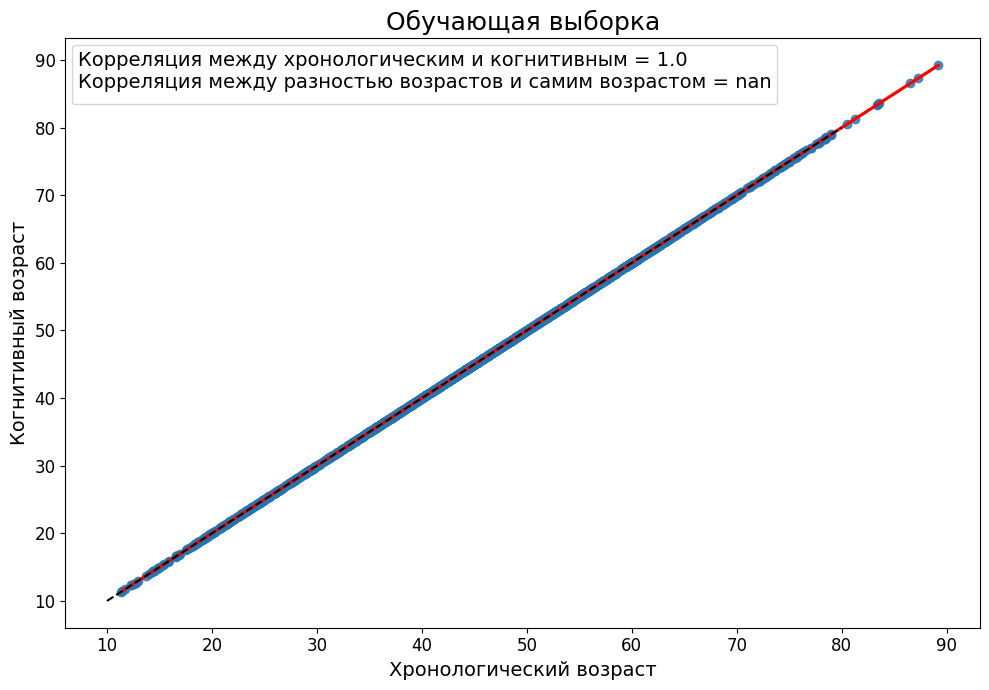

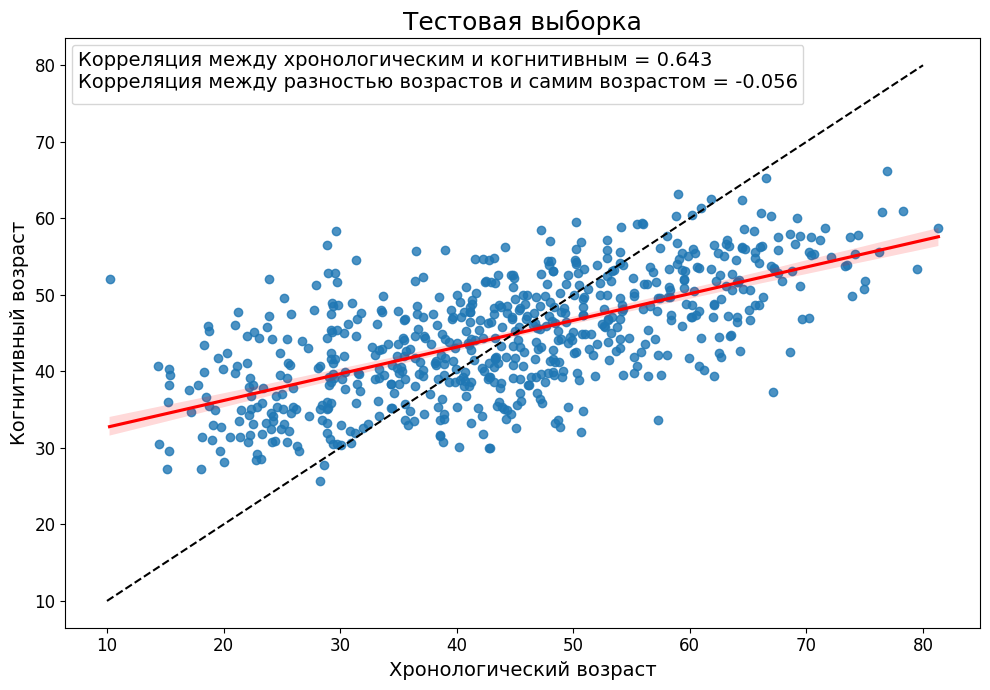

In [11]:
def scatterplot_with_ages(y1, y2, label): 
    ages_df = pd.DataFrame({
        'Хронологический возраст': y1,
        'Когнитивный возраст': y2
    })

    plt.figure(figsize=(10, 7))

    r1, p = pearsonr(y1, y2)
    r2, p = spearmanr(abs(y2 - y1), y1)
    sns.regplot(
        data=ages_df,
        x='Хронологический возраст',
        y='Когнитивный возраст',
        line_kws={'color': 'red'}
    )
    
    plt.legend(title=f'Корреляция между хронологическим и когнитивным = {round(r1, 3)}\nКорреляция между разностью возрастов и самим возрастом = {round(r2, 3)}', loc='upper left', title_fontsize=14)
    # TODO другую корреляцию для |y2 - y1|, y1
    plt.title(label=label, fontsize=18)
    plt.plot([10, 80], [10, 80], 'k--') 
    plt.xlabel('Хронологический возраст', fontsize = 14)
    plt.ylabel('Когнитивный возраст', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


scatterplot_with_ages(y_train, y_train_pred, label='Обучающая выборка')
scatterplot_with_ages(y_test, y_test_pred, label='Тестовая выборка')

# def scatterplot_with_ages(y1, y2, label, ax): 
#     ages_df = pd.DataFrame({
#         'Хронологический возраст': y1,
#         'Когнитивный возраст': y2
#     })

#     plt.figure(figsize=(10, 4))

#     r1, p = pearsonr(y1, y2)
#     r2, p = pearsonr(abs(y1 - y2), y1)
#     sns.regplot(
#         data=ages_df,
#         x='Хронологический возраст',
#         y='Когнитивный возраст',
#         line_kws={'color': 'red'},
#         ax = ax
#     )
    
#     ax.legend(title=f'Корреляция между хронологическим и когнитивным = {round(r1, 3)}\nКорреляция между разностью возрастов и самим возрастом = {round(r2, 3)}', loc='upper left', title_fontsize=14)
#     # TODO другую корреляцию для |y2 - y1|, y1
#     ax.set_title(label=label, fontsize=18)
#     ax.plot([10, 80], [10, 80], 'k--') 
#     ax.set_xlabel('Хронологический возраст', fontsize = 14)
#     ax.set_ylabel('Когнитивный возраст', fontsize=14)
#     ax.tick_params(axis='both', labelsize=12)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))

# scatterplot_with_ages(y_train, y_train_pred, label='Обучающая выборка', ax=ax1)
# scatterplot_with_ages(y_test, y_test_pred, label='Тестовая выборка', ax=ax2)

# plt.tight_layout()
# plt.show()